In [17]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyts.transformation import ROCKET
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score


In [18]:
def load_h5_to_dataframe(file_path):
    with h5py.File(file_path, "r") as f:
        print("Keys: %s" % list(f.keys()))
        
        dataframes = []
        for key in list(f.keys()):
            print(f"Loading {key}: {type(f[key])}")
            dataset = np.array(f[key])
            
            if dataset.ndim > 1:
                num_features = dataset.shape[1]
                columns = [f"{key}_{i}" for i in range(num_features)]
                df = pd.DataFrame(dataset, columns=columns)
            else:
                df = pd.DataFrame(dataset, columns=[key])
            
            dataframes.append(df)
        
        combined_df = pd.concat(dataframes, axis=1)
        return combined_df



In [19]:
# Leer los datos
train_path = 'train.h5'
test_path = 'test.h5'

train_data = load_h5_to_dataframe(train_path)
test_data = load_h5_to_dataframe(test_path)

Keys: ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y']
Loading body_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_z: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loading y: <class 'h5py._hl.dataset.Dataset'>
Keys: ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
Loading body_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loadi

In [20]:
# Dividir los datos en características y etiquetas
X = train_data.drop(columns=['y'])
Y = train_data['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.30, shuffle=True)



In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

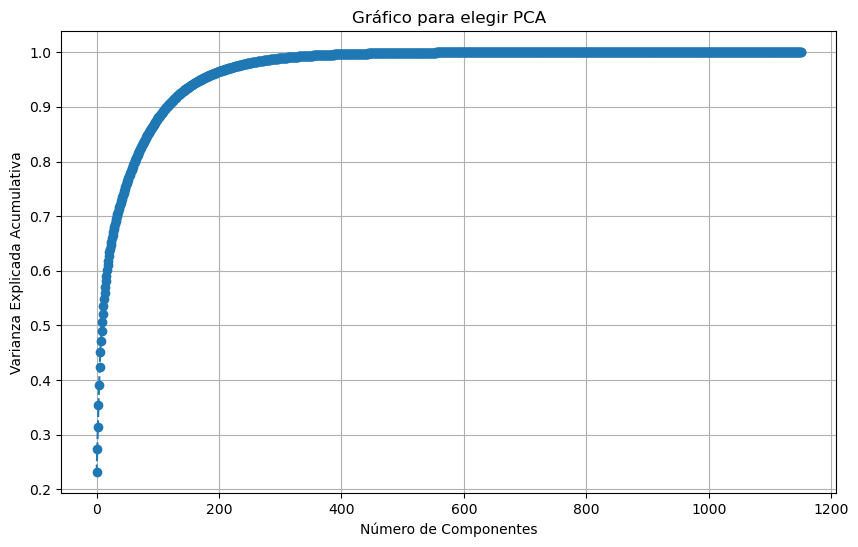

In [22]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA().fit(X_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Gráfico para elegir PCA')
plt.grid(True)
plt.show()

In [23]:
# Seleccionar el número de componentes que explican el 95% de la varianza
n_components = np.argmax(explained_variance >= 0.95) + 1

# Aplicar PCA con el número seleccionado de componentes
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Mejor numero de componentes: {n_components}')

Mejor numero de componentes: 172


In [24]:
# Aplicar ROCKET
rocket = ROCKET()
X_train_rocket = rocket.fit_transform(X_train_pca)
X_test_rocket = rocket.transform(X_test_pca)

In [25]:
# Modelos a utilizar con mayor número de iteraciones para Logistic Regression
# utilizamos 5000 iteraciones para lograr que el modelo converja
models = {
    'Regresion Logistica': LogisticRegression(max_iter=5000),
    'SVM': SVC()
}

# Diccionarios para almacenar los resultados
accuracy_scores = {}
f1_scores = {}
confusion_matrices = {}


In [26]:
for name, model in models.items():
    model.fit(X_train_rocket, y_train)
    y_pred = model.predict(X_test_rocket)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    accuracy_scores[name] = accuracy
    f1_scores[name] = f1
    confusion_matrices[name] = cm
    
    print(f"Modelo Usado: {name}:")
    print("Resultado del Accuracy:", accuracy)
    print("Resultado del F1-Score:", f1)
    print("Reporte del Modelo:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", cm)
    print("\n")

Modelo Usado: Regresion Logistica:
Resultado del Accuracy: 0.9446962828649139
Resultado del F1-Score: 0.9447930176212623
Reporte del Modelo:
               precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       369
         2.0       0.97      0.94      0.95       337
         3.0       0.94      0.91      0.92       285
         4.0       0.90      0.94      0.92       385
         5.0       0.92      0.93      0.92       402
         6.0       1.00      1.00      1.00       428

    accuracy                           0.94      2206
   macro avg       0.94      0.94      0.94      2206
weighted avg       0.95      0.94      0.94      2206

Confusion Matrix:
 [[347   4   9   6   3   0]
 [  5 316   8   2   6   0]
 [ 17   4 260   2   1   1]
 [  0   0   1 360  24   0]
 [  0   1   0  27 374   0]
 [  0   0   0   1   0 427]]


Modelo Usado: SVM:
Resultado del Accuracy: 0.8825929283771532
Resultado del F1-Score: 0.882661838453877
Reporte del Modelo:
       

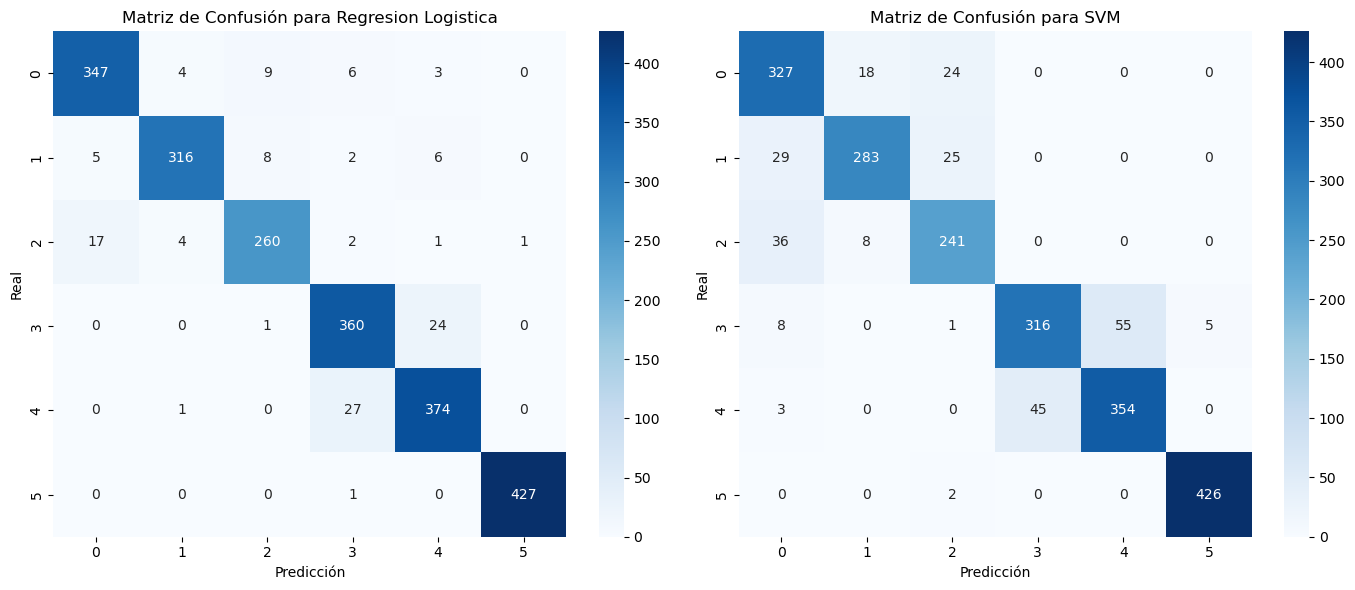

In [27]:
# Graficar las Matrices de Confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión para {name}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()

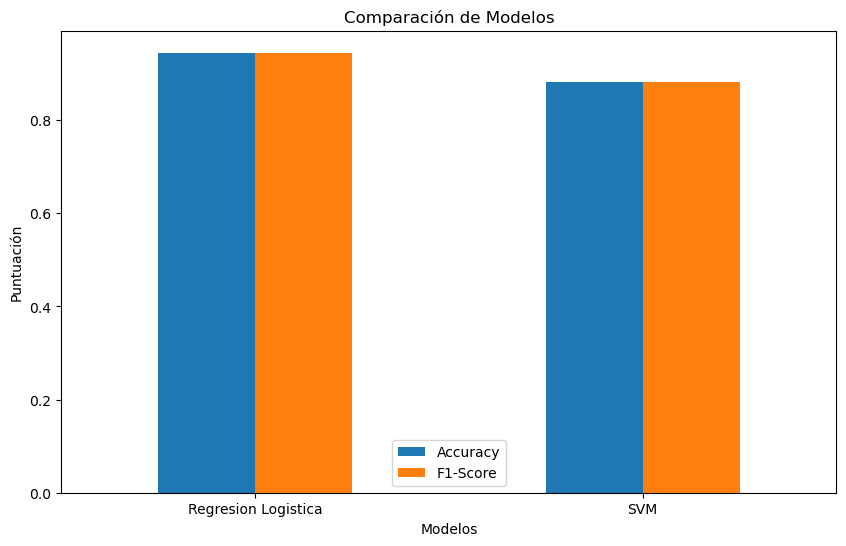

In [28]:
# Comparar los Modelos
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_scores,
    'F1-Score': f1_scores
})

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Puntuación')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [29]:
# Escalar los datos 
X_test_data_scaled = scaler.transform(test_data)

# Aplicar PCA
X_test_data_pca = pca.transform(X_test_data_scaled)

# Aplicar Rocket
X_test_data_rocket = rocket.transform(X_test_data_pca)

In [31]:
# Generar las predicciones con Regresion
logistic_regression_model = models['Regresion Logistica']
predictions = logistic_regression_model.predict(X_test_data_rocket)

In [33]:
# Generar las predicciones con SVM
svm_model = models['SVM']
predictions_svm = svm_model.predict(X_test_data_rocket)

In [32]:
# Crear un DataFrame con las predicciones de regresion
indices = np.arange(1, len(predictions) + 1)
results = pd.DataFrame({'index': indices, 'prediction': predictions})

# Exportar a un archivo CSV
results.to_csv('predicciones.csv', index=False, header=False)

In [34]:
# Crear un DataFrame con las predicciones de SVM
indices_svm = np.arange(1, len(predictions_svm) + 1)
results_svm = pd.DataFrame({'index': indices_svm, 'prediction': predictions_svm})

# Exportar a un archivo CSV
results_svm.to_csv('predicciones_svm.csv', index=False, header=False)